In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.dragonn_deconv_conv_generator_concat import load_generator_network, get_shallow_copy_function
from definitions.predictor.dragonn import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:

class GenesisMonitor(Callback):
    def __init__(self, generator_model, sequence_encoder, run_dir="", run_prefix="", n_sequences=32, batch_size=32, input_tensor_funcs=None) :
        self.generator_model = generator_model
        self.batch_size = batch_size
        self.n_sequences = n_sequences
        self.input_tensor_funcs = input_tensor_funcs
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        self._store_sequences(seqs, 0)
    
    def _sample_sequences(self) :
        n_batches = self.n_sequences // self.batch_size
        
        self.input_tensors = [self.input_tensor_funcs[i](i) for i in range(len(self.input_tensor_funcs))]
        gen_bundle = self.generator_model.predict(x=self.input_tensors, batch_size=self.batch_size)
        _, _, _, _, _, sampled_pwm, _, _, _ = gen_bundle
        
        seqs = [
            self.sequence_encoder.decode(sampled_pwm[i, 0, :, :, 0]) for i in range(sampled_pwm.shape[0])
        ]
        
        return seqs
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.n_sequences) + "_sequences.txt", "wt") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_epoch_end(self, epoch, logs={}) :
        
        seqs = self._sample_sequences()
        self._store_sequences(seqs, epoch)


In [3]:
#Download DragoNN Tutorial 4 models 

## Download SPI1 classification model 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5
#spi1_classification_model=load_dragonn_model("SPI1.classification.model.hdf5")

## Download SPI1 regression model 
#!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
#spi1_regression_model=load_dragonn_model("SPI1.regression.model.hdf5")


In [4]:

#Define margin activity loss function
def get_activity_loss(fitness_target, fitness_weight=2., pwm_start=0, pwm_end=1000, pwm_target_bits=1.8, vae_pwm_start=0, entropy_weight=0.0, entropy_loss_mode='margin', similarity_weight=0.0, similarity_margin=0.5) :
    
    masked_entropy_mse = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, target_bits=pwm_target_bits)
    if entropy_loss_mode == 'margin' :
        masked_entropy_mse = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=pwm_start, pwm_end=pwm_end, margin=similarity_margin, shift_1_nt=True)
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, pred_bind, pred_score = loss_tensors
        
        #Specify costs
        fitness_loss = fitness_weight * K.mean(K.maximum(-K.print_tensor(pred_score[..., 0], message="score_pred=") + fitness_target, K.zeros_like(pred_score[..., 0])), axis=1)
        
        entropy_loss = entropy_weight * masked_entropy_mse(pwm_1, mask)
        
        similarity_loss = similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)
        
        #Compute total loss
        total_loss = fitness_loss + entropy_loss + similarity_loss
        
        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(run_prefix, sequence_templates, loss_func, model_path, batch_size=32, n_samples=1, n_epochs=10, steps_per_epoch=100, n_intermediate_sequences=960) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Validation Generator Network
    _, val_generator = get_generator_copier(generator)(batch_size, len(sequence_templates[0]), get_shallow_copy_function(generator), n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False, validation_sample_mode='sample', supply_inputs=True)
    
    #Build Predictor Network and hook it on the generator PWM output tensor
    _, predictor = build_predictor(generator, load_saved_predictor(model_path), batch_size, n_samples=n_samples, eval_mode='sample')

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(predictor, loss_func)
    
    #Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    
    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)
    
    #Randomized validation tensors
    val_random_tensor_funcs = [
        lambda i: np.array(np.zeros(n_intermediate_sequences)).reshape(-1, 1),
        lambda i: np.random.uniform(-1, 1, (n_intermediate_sequences, 100)),
        lambda i: np.random.uniform(-1, 1, (n_intermediate_sequences, 100))
    ]

    #Standard sequence decoder
    acgt_encoder = IdentityEncoder(1000, {'A':0, 'C':1, 'G':2, 'T':3})
    
    #Build callback for printing intermediate sequences
    random_genesis_monitor = GenesisMonitor(val_generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", n_sequences=n_intermediate_sequences, batch_size=batch_size, input_tensor_funcs=val_random_tensor_funcs)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[random_genesis_monitor]
    )
    
    train_history = None

    return generator, predictor, train_history


In [5]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '')
saved_predictor_model_name = '../../../seqprop/examples/dragonn/SPI1.classification.model.hdf5'
saved_predictor_model_path = os.path.join(save_dir, saved_predictor_model_name)


In [6]:
#Maximize isoform proportions for all native minigene libraries

sequence_templates = [
    'N' * 1000
]


In [7]:
#Train MPRA-DragoNN GENESIS Network

print("Training GENESIS")

model_prefix = "genesis_dragonn_max_spi1_25000_updates_similarity_margin_02_earthmover_weight_01_target_700_fixed"

#Number of PWMs to generate per objective
batch_size = 64
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
#Number of epochs per objective to optimize
n_epochs = 150#250
#Number of steps (grad updates) per epoch
steps_per_epoch = 100

#Number of sequences to sample and store for each epoch
n_intermediate_sequences = 960

K.clear_session()

loss = get_activity_loss(
    70.0,
    fitness_weight=0.1,
    pwm_start=0,
    pwm_end=1000,
    pwm_target_bits=1.8,
    entropy_weight=0.5,
    entropy_loss_mode='margin',
    similarity_weight=5.0,
    similarity_margin=0.2,
)

generator_model, predictor_model, train_history = run_genesis(model_prefix, [sequence_templates[0]], loss, saved_predictor_model_path, batch_size, n_samples, n_epochs, steps_per_epoch, n_intermediate_sequences)

generator_model.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
generator_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
generator_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

predictor_model.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
predictor_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
predictor_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = model_prefix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = model_prefix + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)
predictor_model.save(model_path)
print('Saved trained model at %s ' % model_path)

#0.01 at beginning of epoch 3

Training GENESIS
Epoch 1/150
100/100 [==============================] - 16s 163ms/step - loss: 4.7470
Epoch 2/150
100/100 [==============================] - 8s 77ms/step - loss: 1.0085
Epoch 3/150
100/100 [==============================] - 8s 76ms/step - loss: 0.7884
Epoch 4/150
100/100 [==============================] - 8s 77ms/step - loss: 0.7327
Epoch 5/150
100/100 [==============================] - 8s 76ms/step - loss: 0.7167
Epoch 6/150
100/100 [==============================] - 8s 76ms/step - loss: 0.6932
Epoch 7/150
100/100 [==============================] - 8s 77ms/step - loss: 0.6626
Epoch 8/150
100/100 [==============================] - 8s 77ms/step - loss: 0.6553
Epoch 9/150
100/100 [==============================] - 8s 76ms/step - loss: 0.6445
Epoch 10/150
100/100 [==============================] - 8s 77ms/step - loss: 0.6228
Epoch 11/150
100/100 [==============================] - 8s 77ms/step - loss: 0.6155
Epoch 12/150
100/100 [==============================] - 8s 77ms/st

In [8]:
#Specfiy file path to pre-trained predictor network

saved_predictor_model_path = "../../../seqprop/examples/dragonn/SPI1.classification.model.hdf5"

def _dummy_min_pred(y_true, y_pred) :
    return y_pred

saved_predictor = load_model(saved_predictor_model_path, custom_objects={
    'ambig_binary_crossentropy' : _dummy_min_pred,
    'precision' : _dummy_min_pred,
    'recall' : _dummy_min_pred,
    'specificity' : _dummy_min_pred,
    'fpr' : _dummy_min_pred,
    'fnr' : _dummy_min_pred,
    'fdr' : _dummy_min_pred,
    'f1' : _dummy_min_pred
})

saved_predictor = Model(
    inputs=saved_predictor.inputs,
    outputs = [saved_predictor.get_layer('dense_2').output]
)

saved_predictor.compile(
    loss='mse',
    optimizer=keras.optimizers.SGD(lr=0.1)
)


acgt_encoder = IdentityEncoder(1000, {'A':0, 'C':1, 'G':2, 'T':3})


In [10]:
#Load and re-save version of generator where train=True set on batchnorm layers

#Build Generator Network
_, generator = build_generator(64, 1000, load_generator_network, n_classes=1, n_samples=10, sequence_templates=sequence_templates, batch_normalize_pwm=False)

#Build Validation Generator Network
_, generator_trainmode = get_generator_copier(generator)(64, 1000, get_shallow_copy_function(generator), n_classes=1, n_samples=10, sequence_templates=sequence_templates, batch_normalize_pwm=False, validation_sample_mode='sample', supply_inputs=False)



In [11]:

generator_trainmode.load_weights("saved_models/genesis_dragonn_max_spi1_25000_updates_similarity_margin_02_earthmover_weight_01_target_700_fixed_generator.h5")


In [13]:

generator_trainmode.get_layer('lambda_rand_sequence_class_copy_1').function = lambda inp: inp
generator_trainmode.get_layer('lambda_rand_input_1').function = lambda inp: inp
generator_trainmode.get_layer('lambda_rand_input_2').function = lambda inp: inp


In [14]:

generator = generator_trainmode


In [15]:

model_name = model_prefix + '_trainmode_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at saved_models/genesis_dragonn_max_spi1_25000_updates_similarity_margin_02_earthmover_weight_01_target_700_fixed_trainmode_generator.h5 


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


score_pred = 75.81558


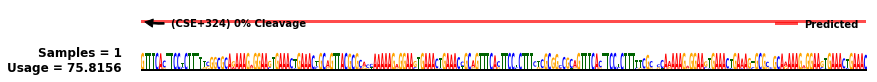

score_pred = 73.90916


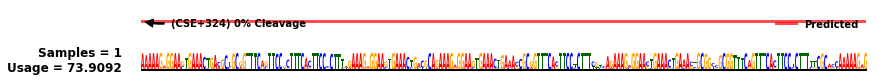

score_pred = 72.12181


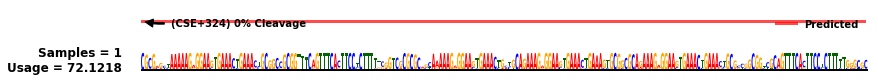

score_pred = 70.75448


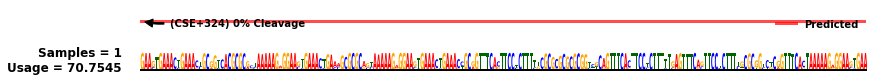

score_pred = 74.941444


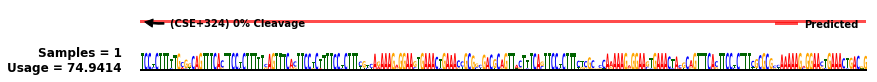

score_pred = 74.30662


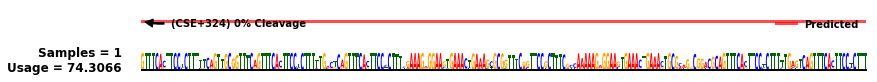

score_pred = 76.560616


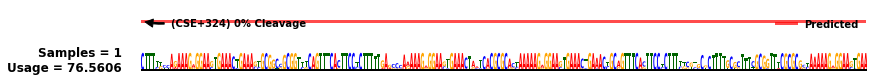

score_pred = 74.61046


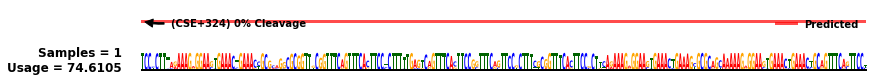

score_pred = 73.12733


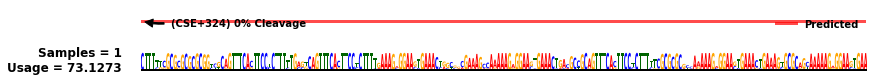

score_pred = 71.5648


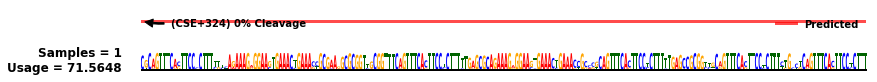

score_pred = 71.6491


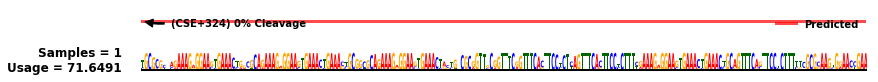

score_pred = 74.79465


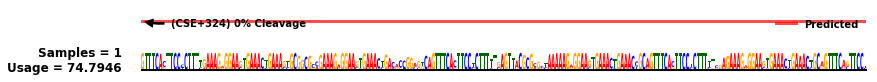

score_pred = 70.59472


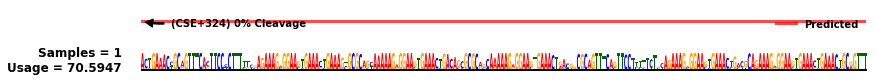

score_pred = 75.959015


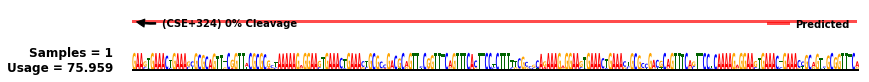

score_pred = 72.22918


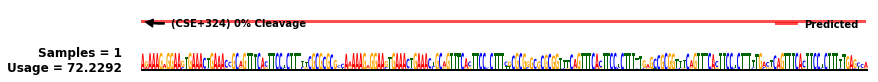

score_pred = 74.369865


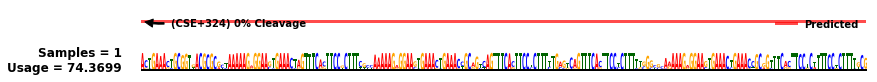

In [16]:
#Load GENESIS models and predict sample sequences

model_prefix = "genesis_dragonn_max_spi1_25000_updates_similarity_margin_02_earthmover_weight_01_target_700_fixed_trainmode"
batch_size = 64

sequence_template = sequence_templates[0]

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = model_prefix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)

generator = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})

n = batch_size

sequence_class = np.array([0] * n).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

#Make predictions using black box model

score_pred = saved_predictor.predict(x=[np.expand_dims(sampled_pwm[:, 0, :, :, 0], axis=1)], batch_size=batch_size)

for pwm_index in range(16) :

    print("score_pred = " + str(score_pred[pwm_index, 0]))
    
    pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
    cut = np.zeros((1, 1000))
    sco = np.expand_dims(np.expand_dims(score_pred[pwm_index, 0], axis=0), axis=-1)

    plot_seqprop_logo(pwm, sco, cut, annotate_peaks='max', sequence_template=sequence_templates[0], figsize=(12, 1.25), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=400, plot_end=600)


In [17]:
#Load GENESIS models and predict sample sequences

n = 1000
n_slack = 0.05 * n

n_ceil = int((n + n_slack) / batch_size) * batch_size + batch_size

sequence_class = np.array([0] * n_ceil).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

pwms = optimized_pwm[:, :, :, 0]
onehots = sampled_pwm[:, 0, :, :, 0]

#Make predictions using black box model

score_pred = saved_predictor.predict(x=[np.expand_dims(onehots, axis=1)], batch_size=batch_size)

score_pred = np.ravel(score_pred[:, 0])

sort_index = np.argsort(score_pred)[::-1]

pwms = pwms[sort_index][:n]
onehots = onehots[sort_index][:n]
score_pred = score_pred[sort_index][:n]


mean score = 74.8865
std score = 2.0378
-------------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


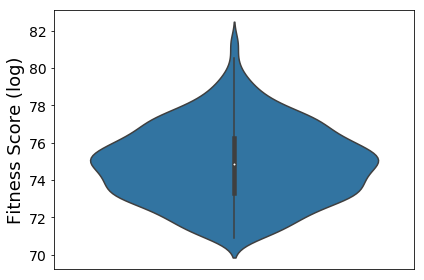

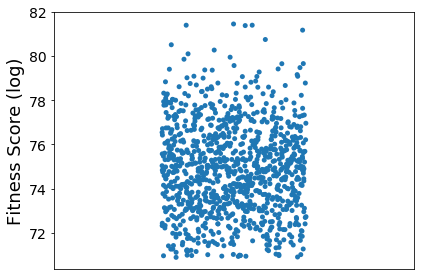

In [18]:
import seaborn as sns

save_figs = False

print("mean score = " + str(round(np.mean(score_pred), 4)))
print("std score = " + str(round(np.std(score_pred), 4)))
print("-------------------------")

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[score_pred])

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Fitness Score (log)', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_fitness_score_violin.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_fitness_score_violin.eps")
    plt.savefig(model_prefix + "_fitness_score_violin.svg")

plt.show()

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[score_pred], jitter=1.)

plt.xlim(-0.25, 0.25)

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Fitness Score (log)', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_fitness_score_stripplot.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_fitness_score_stripplot.eps")
    plt.savefig(model_prefix + "_fitness_score_stripplot.svg")

plt.show()


In [19]:
#Calculate average/std nucleotide entropy

nt_entropies = []
for j in range(onehots.shape[1]) :
    if sequence_templates[0][j] == 'N' :

        p_A = np.sum(onehots[:, j, 0]) / n
        p_C = np.sum(onehots[:, j, 1]) / n
        p_G = np.sum(onehots[:, j, 2]) / n
        p_T = np.sum(onehots[:, j, 3]) / n

        nt_entropy = 0
        if p_A * p_C * p_G * p_T > 0. :
            nt_entropy = - (p_A * np.log2(p_A) + p_C * np.log2(p_C) + p_G * np.log2(p_G) + p_T * np.log2(p_T))

        nt_entropies.append(nt_entropy)

nt_entropies = np.array(nt_entropies)

print("Mean NT Entropy = " + str(round(np.mean(nt_entropies), 4)))
print("Std NT Entropy = " + str(round(np.std(nt_entropies), 4)))


#Calculate hexamer entropies

hexamer_encoder = isol.NMerEncoder(n_mer_len=6, count_n_mers=True)

hexamers = isol.SparseBatchEncoder(encoder=hexamer_encoder)([
    acgt_encoder.decode(onehots[i, :, :]) for i in range(onehots.shape[0])
])

hexamer_sum = np.ravel(hexamers.sum(axis=0))
hexamers_probs = hexamer_sum / np.sum(hexamer_sum)
n_nonzero_hexamers = len(np.nonzero(hexamer_sum > 0)[0])

print("Number of unique hexamers = " + str(n_nonzero_hexamers))

hexamer_entropy = -1. * np.sum(hexamers_probs[hexamer_sum > 0] * np.log2(hexamers_probs[hexamer_sum > 0]))

print("Hexamer Entropy = " + str(hexamer_entropy))


#Calculate average/std hexamer entropy

nonzero_index = np.nonzero(hexamer_sum > 0)[0]

hexamer_entropies = []
for j in range(n_nonzero_hexamers) :
    p_on = len(np.nonzero(hexamers[:, nonzero_index[j]] > 0)[0]) / hexamers.shape[0]
    p_off = 1. - p_on

    hexamer_entropy = 0
    if p_on * p_off > 0. :
        hexamer_entropy = -(p_on * np.log2(p_on) + p_off * np.log2(p_off))

    hexamer_entropies.append(hexamer_entropy)

hexamer_entropies = np.array(hexamer_entropies)

print("Mean Binary Hexamer Entropy = " + str(round(np.mean(hexamer_entropies), 4)))
print("Std Binary Hexamer Entropy = " + str(round(np.std(hexamer_entropies), 4)))



Mean NT Entropy = 1.8343
Std NT Entropy = 0.0835
Number of unique hexamers = 3595
Hexamer Entropy = 8.302790595638253
Mean Binary Hexamer Entropy = 0.2057
Std Binary Hexamer Entropy = 0.2629


mean distance/nt = 0.3959
std distance/nt = 0.0207
-------------------------


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


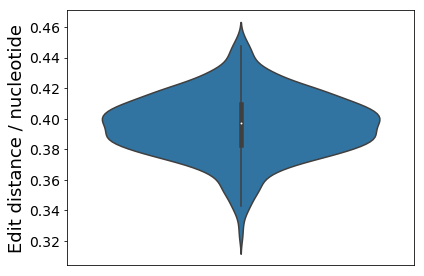

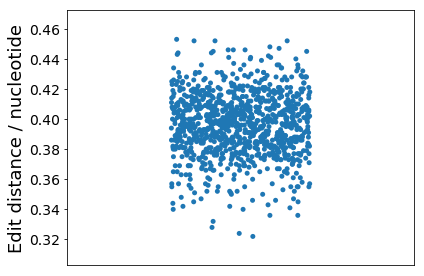

In [20]:
import editdistance

#Calculate random pair-wise edit distances

save_figs = False

seqs = [
    acgt_encoder.decode(onehots[i, :, :]) for i in range(onehots.shape[0])
]

shuffle_index = np.arange(len(seqs))
np.random.shuffle(shuffle_index)

distances = []
for i in range(len(seqs)) :
    if i == shuffle_index[i] :
        continue
    
    seq_1 = seqs[i]
    seq_2 = seqs[shuffle_index[i]]
    
    dist = editdistance.eval(seq_1, seq_2)

    distances.append(dist)

    import seaborn as sns

distances = np.array(distances) / np.sum([1 if sequence_templates[0][j] == 'N' else 0 for j in range(len(sequence_templates[0]))])

print("mean distance/nt = " + str(round(np.mean(distances), 4)))
print("std distance/nt = " + str(round(np.std(distances), 4)))
print("-------------------------")

f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[distances])

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Edit distance / nucleotide', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_edit_distance_violin.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_edit_distance_violin.eps")
    plt.savefig(model_prefix + "_edit_distance_violin.svg")

plt.show()

f = plt.figure(figsize=(6, 4))

sns.stripplot(data=[distances], jitter=1.)

plt.xlim(-0.25, 0.25)

plt.xticks([], [])
plt.yticks(fontsize=14)

plt.ylabel('Edit distance / nucleotide', fontsize=18)

plt.tight_layout()

if save_figs :
    plt.savefig(model_prefix + "_edit_distance_stripplot.png", transparent=True, dpi=150)
    plt.savefig(model_prefix + "_edit_distance_stripplot.eps")
    plt.savefig(model_prefix + "_edit_distance_stripplot.svg")

plt.show()


In [22]:
#Load GENESIS models and predict sample sequences

batch_size = 64

n = 4096
n_slack = 0

n_ceil = int((n + n_slack) / batch_size) * batch_size
if n_ceil < n :
    n_ceil += batch_size

sequence_class = np.array([0] * n_ceil).reshape(-1, 1)

noise_1 = np.random.uniform(-1, 1, (n_ceil, 100))
noise_2 = np.random.uniform(-1, 1, (n_ceil, 100))

pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs

pwms = optimized_pwm[:, :, :, 0]
onehots = sampled_pwm[:, 0, :, :, 0]

#Make predictions using black box model

score_pred = saved_predictor.predict(x=[np.expand_dims(onehots, axis=1)], batch_size=batch_size)

score_pred = np.ravel(score_pred[:, 0])

sort_index = np.argsort(score_pred)[::-1]

pwms = pwms[sort_index][:n]
onehots = onehots[sort_index][:n]
score_pred = score_pred[sort_index][:n]


In [23]:
#Save sequences to file
with open(model_prefix + "_4096_sequences.txt", "wt") as f:
    for i in range(onehots.shape[0]) :
        seq = acgt_encoder.decode(onehots[i])
        
        f.write(seq + "\n")
